# Acknowledge
- Researcher: Changhun Lee, Jiyeon Hong, Hyeonchang Lee
- You can view all source code and data in the real-time inflation forecast pipeline in Gitlab page:[[Gitlab 디지털신기술팀/inflation_forecasting]](https://bidas-gitlab.boknet.intra/digitaltech/inflation_forecasting)
- BOK Issue Note "[제2024-5호] 빅데이터와 기계학습 알고리즘을 활용한 실시간 인플레이션 전망(real-time inflation forecasting)"[[💾Download issue note]](https://bidas-s3.boknet.intra/newtech/public/inf_nowcasting/이슈노트2024-5호.pdf)
- Please refer to the Excel file for the exact variable name of the predictor ID related to contribution decomposition by variable.<a href="https://bidas-s3.boknet.intra/newtech/public/inf_nowcasting/data_id_list.pdf" download>[💾Download variable list]</a>

## System Overview
- ### Provides information on future price path through visualized real-time forecast results
    - Every Friday, we update current-month, 3-month, and 12-month inflation forecasts using newly acquired data, and decompose the contribution of each variable.
- ### Applied ensembled model of machine learning algorithm (EXT) and linear regression model
    - Machine learning algorithms are suitable for utilizing big data and solving model identification error problems, and linear regression models provide relatively excellent prediction performance when the number of data is insufficient.
    - Improving forecast performance using ensemble techniques (average of EXT and linear regression model forecasts)
- ### Utilize Python/Jupyter Notebook/Gitlab and container technology
    - Easy to develop agile forecast models, automate operations, share forecast results and development know-how, and accumulate   

# View real-time inflation forecast results from the past

In [ ]:
!git clone https://github.com/kms9561/Inflation_Forecast.git

In [1]:
from datetime import datetime
this_year = datetime.now().year
last_month = datetime.now().month - 1

# Model training and out-of-sample predictive power evaluation (annually re-estimated)

- In this environment, the model was estimated using only 2018 data.

In [4]:
#import import_ipynb
import sys
sys.path.insert(0, '/content/Inflation_Forecast/')
from train_models import *

In [5]:
DO_TRAIN = False
DO_HYPERPARAMETER_TUNE = False # if True, train models with all hyperparameter combinations. if False, only train best models
GET_EVALUATION_PLOT = False

In [6]:
local_path = set_local_path()

In [7]:
model_types = ['reg', 'ext'] #['arima', 'rw', 'reg', 'ext']

if DO_TRAIN:
    train_models(model_types, DO_HYPERPARAMETER_TUNE) 
    predict_and_plot(model_types, GET_EVALUATION_PLOT)

# Actual inflation Rate in 2018, Korea

In [12]:
#Korean Font Setting
font_path='/content/Inflation_Forecast/Fonts/NanumGothicCoding.ttf'
font_name=plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams["font.family"]="NanumGothicCoding"
plt.rcParams['axes.unicode_minus']=False

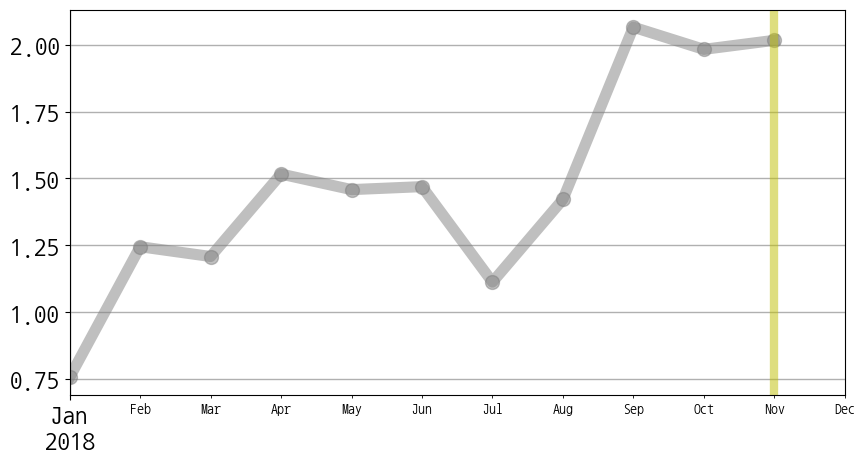

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
for ax, h in zip([axs], [0]):
    act[targets].loc['2017':].plot(ax=ax, lw=8, color='gray', marker='o', markersize=10, alpha=0.5)
    ax.grid(which='major', lw=1)   
    ax.tick_params(axis="both", labelsize=18)
    for x in ['2018-11-30', '2020-10-31', '2022-07-31']:
        ax.axvline(x=x, lw=6, color='y', alpha=0.5)

# Forecast model by forecast period

In [16]:
ens_models = get_ens_models()
ens_best = get_best_ens_models(ens_models)

In [18]:
today = pd.Timestamp(datetime.now().strftime('%Y-%m-%d'))
vintages = pd.date_range('2018-01-01', '2018-12-31', freq='W-FRI')
#다 빼오기 그래서 2018년만
_, act_vintage = get_train_data_v5(DF_vintages[vintages[-1]])
last_inf_month = act_vintage.dropna().index[-1]
last_inf = act_vintage.dropna().iloc[-1]
print(f"The latest inflation is {last_inf:.2f} for {last_inf_month:%Y-%m}")

#this_month = (pd.Timestamp(datetime.now()) - timedelta((datetime.now().weekday() + 3)%7)).strftime('%Y-%m')
this_month = last_inf_month + MonthBegin(1) # inf 실제치가 존재하는 월의 그 다음달 기준으로 예측

The latest inflation is 2.02 for 2018-11


# Contribution decomposition

In [20]:
from collections import OrderedDict

In [22]:
for month in [this_month]:
    fm = month + MonthEnd(0)
    
    if today.strftime('%Y-%m-%d') != vintages[-1].strftime('%Y-%m-%d'):
        print(f"{today} is not Friday.")
        continue

    for h in [0, 3, 12]:

        tm = fm + MonthEnd(h)
        model_names = ens_models[ens_best[h]] # h=0: ens103, h=3: ens1005, h=12: ens35}
        print(model_names)
        print(f"\nhor : {h} months, fm : {fm:%Y-%m}, tm : {tm:%Y-%m}")
        print(', '.join(model_names))

        PRED_DECOMP = pd.DataFrame()
        
        print(f'{fm:%Y-%m-%d}')


        for mname in model_names:
            print(f"\ndecomposing {mname} ...")
            try:
                download_from_s3(f"{s3_repo_path}/model/{mname}_{tm.year}-01_h{h}.pkl", f"{local_path}/model/")
                model = joblib.load(f"{local_path}/model/{mname}_{tm.year}-01_h{h}.pkl")
                
            except:
                print(f"Model for {tm.year - 1} is loaded instead of {tm.year}, which does NOT exist.")
                try:
                    download_from_s3(f"{s3_repo_path}/model/{mname}_{tm.year - 1}-01_h{h}.pkl", f"{local_path}/model/")
                    model = joblib.load(f"{local_path}/model/{mname}_{tm.year - 1}-01_h{h}.pkl")
                except:
                    print("Model NOT exist!!")
                    continue

            fm_vintages = [date for date in vintages if (date.month == fm.month) and (date.year == fm.year)]
            if vintages[-1] not in fm_vintages: # 공표 전에 월이 바뀐경우, 전 달에 이어서 생성
                fm_vintages.append(vintages[-1])
                
            if h == 0:
                pm = fm - MonthEnd(1)
                pm_vintages = [Nth_friday(pm.year, pm.month, i) for i in [-3, -2, -1]]
            else:
                pm_vintages = [Nth_friday(m.year, m.month, -1) for m in [fm - MonthEnd(i) for i in [3, 2, 1]]]

            decomp_vintages = pm_vintages + fm_vintages
            #decomp_vintages = list(set(decomp_vintages)) # 중복제거
            decomp_vintages = list(OrderedDict.fromkeys(decomp_vintages))
            
            pred = pd.DataFrame(index=decomp_vintages, columns=['forecast'])

            rolling = int(mname.split('_roll')[1].split('_')[0])
            lag = int(mname.split('_lag')[1].split('_')[0])

            if mname.split('_')[0] == 'lm':
                data_group = mname.split('_model')[1].split(':')
                excl_alt = False
            else:
                data_group = int(mname.split('_g')[1].split('_')[0])
                excl_alt = True

            df0 = DF_vintages[decomp_vintages[0]].copy()
            X0, _ = get_train_data_v5(df0, lag, data_group, excl_alt, fm, rolling=rolling)

            if mname.split('_')[0] == 'lm':
                pred0 = model.predict(X0.loc[[fm]])[0]
            else:
                if h == 12:
                    X0 = X0.drop(['P_eir'], axis = 1)
                else:
                    pass
                pred0 = model.predict(X0.loc[[fm]])[0] + last_inf

            decomp = pd.DataFrame(index=decomp_vintages[1:], columns=df0.columns)
            pred.loc[decomp_vintages[0], 'forecast'] = pred0

            for v in decomp_vintages[1:]:
                print(f"{v:%m-%d}", end=' ')
                df1 = DF_vintages[v].copy()

                for col in df0.columns: ####################
                    df0 = df0.reindex(df1.index)
                    try:
                        df0.loc[:, col] = df1.loc[:, col].copy()
                    except:
                        pass

                    X1, _ = get_train_data_v5(df0, lag, data_group, excl_alt, fm, rolling=rolling)
                    if mname.split('_')[0] == 'lm':
                        pred1 = model.predict(X1.loc[[fm]])[0]
                    else:
                        if h == 12:
                            X1 = X1.drop(['P_eir'], axis = 1)
                        else:
                            pass
                        pred1 = model.predict(X1.loc[[fm]])[0] + last_inf
                    diff = pred1 - pred0
                    if np.abs(diff) > 0.001:
                        print(f"({col}){diff:.3f}", end=' ')
                    decomp.loc[v, col] = diff
                    pred0 = pred1

                pred.loc[v, 'forecast'] = pred1
                print(f"({pred1:.3f})")

            decomp = decomp.applymap(lambda x: np.nan if np.abs(x) < 0.0001 else x)
            decomp = decomp.dropna(how='all', axis=1)
            pred_decomp = pd.concat([pred, decomp], axis=1)
            pred_decomp = pd.concat([pred_decomp], axis=1, keys=[mname])
            PRED_DECOMP = pd.concat([PRED_DECOMP, pred_decomp], axis=1)

        PRED_DECOMP.to_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
        upload_to_s3(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl", output_s3_dir)

2024-12-04 00:00:00 is not Friday.


# Real-time inflation forecast dashboard

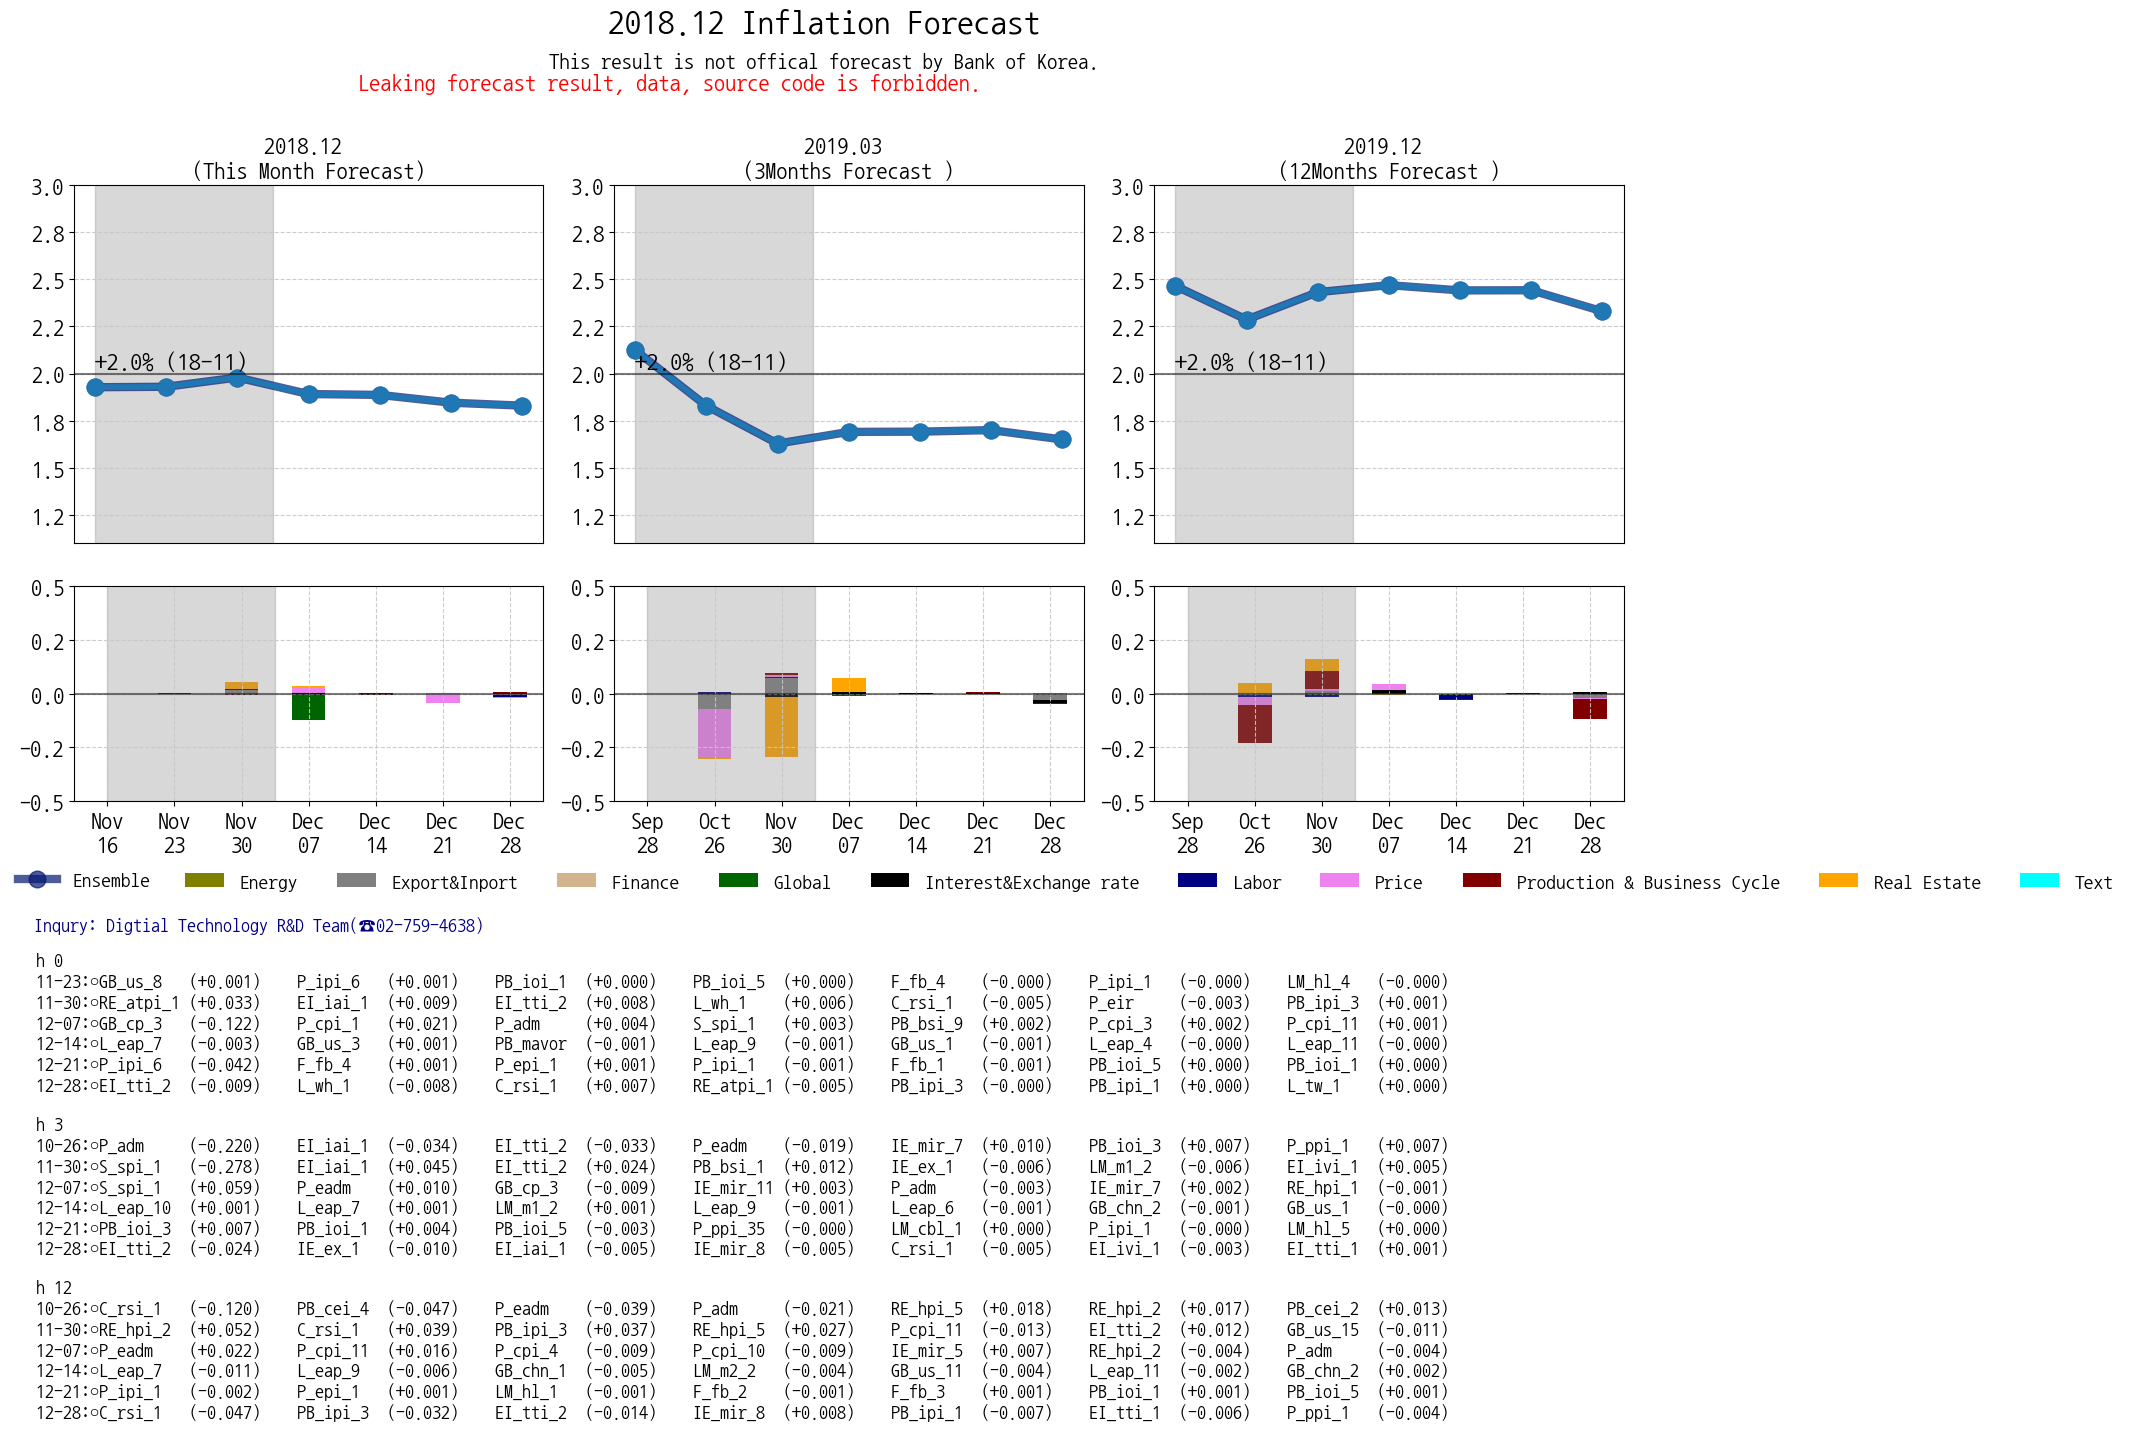

In [24]:
present_results = True
year_month = this_month if present_results else '2024-5-1'
    
fm = pd.Timestamp(year_month) + MonthEnd() # 최근 cpi 공표된 다음달

fig, axs = plt.subplots(2, 3, figsize=(20, 8),
                        gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3],
                                     'wspace': 0.15, 'hspace': 0.15})
margin = 0.5
margin0 = 0.1

DECOMP_VAR = {}
print_decomp_var = True

#vspec = pd.read_excel(f'{input_s3_dir}/data_list_all_v5.xlsx', index_col = None)
vspec = pd.read_excel('/content/Inflation_Forecast/input/data_list_all_v5.xlsx', index_col = None)
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']
vintage_s3_dir='/content/Inflation_Forecast/output/mdata'
#df = pd.read_csv(f'{vintage_s3_dir}/{today:%Y-%m-%d}.csv', index_col=0)
df = pd.read_csv('/content/Inflation_Forecast/input/mdata/2018-12-28.csv', index_col=0)
df.index = pd.to_datetime(df.index)
output_s3_dir='/content/Inflation_Forecast/output'
_, act = get_train_data_v5(df)
act = act.dropna()

pm = fm - MonthEnd(1)

try:
    ymax = act.loc[pm]
    ymin = act.loc[pm]
except KeyError: # 첫째주 금요일 되기 전까지
    pm = fm - MonthEnd(2)
    ymax = act.loc[pm]
    ymin = act.loc[pm]

dymax = 0
dymin = 0

forecastm = pd.DataFrame()

for i, h in enumerate([0, 3, 12]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"{output_s3_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    if DO_TRAIN and not has_s3key():
        PRED_DECOMP = pd.read_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    _, act_vintage = get_train_data_v5(DF_vintages[decomp.index[-1]])
    
    today_str = today.strftime('%Y-%m-%d')
    #print(today_str)

    last_inf = act_vintage.dropna().iloc[-1] # 12월은 당월 공표되어 -2로
    #print(act_vintage)
    
    #if present_results:
    #    inf = pd.read_csv(f'{input_s3_dir}/mdata/{today_str}_raw.csv', index_col = None) #{today_str}_raw.csv
    #    inf = inf['P_cpi_1']
    #    inf = inf.dropna()
    #    inf = inf.pct_change(12)*100
    #    last_inf = inf.iloc[-1]
    #else:
    #    last_inf = act_vintage.dropna().iloc[-1]

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    #forecastm = forecastm.append(forecast)
    forecastm = pd.concat([forecastm, forecast])
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'Energy', 'EI':'Export&Inport', 'F':'Finance', 'GB':'Global',
                                    'IE': 'Interest&Exchange rate', 'L':'Labor', 'P':'Price', 'PB':'Production & Business Cycle', 'RE':'Real Estate','T':'Text'})

    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))
    
    bcolors = [(218 / 256, 238 / 256, 243 / 256), (242 / 256, 220 / 256, 219 / 256), (142 / 256, 186 / 256, 66 / 256),
               (192 / 256, 0 / 256, 0 / 256), (0 / 256, 0 / 256, 0 / 256), (251 / 256, 193 / 256, 94 / 256), 
               (33 / 256, 89 / 256, 103 / 256), (119 / 256, 119 / 256, 119 / 256), (255 / 256, 165 / 256, 0 / 256), (0 / 256, 255 / 256, 255 / 256)]
    bcolors = ['olive', 'grey', 'tan', 'darkgreen', 'black', 'navy', 'violet', 'maroon', 'orange', 'cyan']
    
    bok_blue = (0 / 256, 145 / 256, 218 / 256)

    df['forecast'].plot(ax=axs[0, i], lw=6, marker="o", color=(0.01, 0.09, 0.44), markersize=12, alpha=0.7, label='Ensemble') #color=(0.01, 0.09, 0.44)
    axs[0, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b') # color='b'
    axs[0, i].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1, i], color=bcolors)
    axs[1, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1, i].set_xticklabels(ticklabels, rotation=0)
    axs[0, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[0, i].axhline(y=round(last_inf, 1), lw=1.5, color='k', alpha=0.5)
    axs[1, i].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min(), ymin)
    ymax = max(df.iloc[:, 0].max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max(), dymax)
    #ymin = min(df.iloc[:, 0].min().min(), ymin)
    #ymax = max(df.iloc[:, 0].max().max(), ymax)
    #dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    axs[0, i].legend(ncol= 1, loc=1, frameon=False, bbox_to_anchor=(0.2, -0.869), fontsize=14) #########################
    axs[1, i].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.2, -0.5), fontsize=14) # 0.08
    axs[0, i].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    axs[1, i].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    
    if h == 0:
        axs[0, i].set_title(f"{tm:%Y.%m} \n(This Month Forecast)", fontsize=16)
    else:
        axs[0, i].set_title(f"{tm:%Y.%m} \n({h}Months Forecast )", fontsize=16)
    axs[0, i].tick_params(axis="both", labelsize=16)
    axs[1, i].tick_params(axis="both", labelsize=16)
    axs[0, i].get_xaxis().set_visible(False)
    axs[0, i].text(0.0, round(last_inf, 1), f"{last_inf:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    if i > 0:
        axs[0, i].get_legend().remove()
        axs[1, i].get_legend().remove()
        
    if not present_results:
        try:
            axs[0, i].text(0.95, 0.93, f"Real Value: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)
        except:
            axs[0, i].text(0.95, 0.93, f"Real Value: NA", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)

    axs[0, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([0, 3, 12]):
    axs[0, i].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1, i].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))
    
fig.suptitle(f"{fm:%Y.%m} Inflation Forecast", fontsize=24, y=1.1)

text4 = '\n\nInqury: Digtial Technology R&D Team(☎02-759-4638)\n\n'
fig.text(0.105, -0.1, f'{text4}', fontsize=13, color='navy') # 0., -.15,

warning = [
    "This result is not offical forecast by Bank of Korea.\n",\
    "Leaking forecast result, data, source code is forbidden."]

for i, text in enumerate(warning):
    x_position = 0.423 if i == 1 else 0.5 if i == 0 else 0.592
    color = 'red' if i == 1 else 'black'
    fontsize = 16 if i == 1 else 15
    fig.text(x_position, 1, text, transform=fig.transFigure, ha='center', fontsize=fontsize, color=color)

text = ''
for h in [0, 3, 12]:
    text += f"\n\nh {h} "
    #print(f"\n\nforecasting horizon: {h}", end='')
    df = DECOMP_VAR[h].drop('forecast', axis=1)
    for i in df.index[1:]:
        vars = np.abs(df).loc[i].nlargest(7).index
        text += f"\n{i:%m-%d}:\t"
        #print(f"\n{i:%m-%d}:", end='\t')
        for v in vars:
            text += f"{v:<10}({df.loc[i, v]:+.3f})    "

if print_decomp_var:
    fig.text(0.106, -0.03, text, fontsize=13, horizontalalignment='left', verticalalignment='top')

In [30]:
## Output forecast results by forecast period
print('==========================================')
print(forecastm.T.round(2).iloc[-4:]) 
gap = forecastm.T - forecastm.T.shift(1)
print('-----------------------------------------')
print(gap.round(2).iloc[-1])
print('==========================================')

          2018-11-16  2018-11-23  2018-11-30  2018-12-07  2018-12-14  \
forecast        1.93        1.93        1.98        1.89        1.89   

          2018-12-21  2018-12-28  2018-09-28  2018-10-26  2018-11-30  ...  \
forecast        1.85        1.83        2.12        1.83        1.63  ...   

          2018-12-14  2018-12-21  2018-12-28  2018-09-28  2018-10-26  \
forecast        1.69         1.7        1.65        2.46        2.29   

          2018-11-30  2018-12-07  2018-12-14  2018-12-21  2018-12-28  
forecast        2.43        2.47        2.44        2.44        2.33  

[1 rows x 21 columns]
-----------------------------------------
2018-11-16   NaN
2018-11-23   NaN
2018-11-30   NaN
2018-12-07   NaN
2018-12-14   NaN
2018-12-21   NaN
2018-12-28   NaN
2018-09-28   NaN
2018-10-26   NaN
2018-11-30   NaN
2018-12-07   NaN
2018-12-14   NaN
2018-12-21   NaN
2018-12-28   NaN
2018-09-28   NaN
2018-10-26   NaN
2018-11-30   NaN
2018-12-07   NaN
2018-12-14   NaN
2018-12-21   NaN
2018-12-

In [32]:
# Result of inflation forecast
text = ''
for h, i, s in zip([0, 3], [0, 1], ['This Month', 'After 3 Months']):
    if gap.round(2).iloc[-1,i] < 0:
        now = '하향'
    elif gap.round(2).iloc[-1,i] > 0:
        now = '상향'
    else: # 변동 없는 경우
        text += f"- ({s} Forecast) {fm + MonthEnd(h):%Y.%m} Forecast: {forecastm.T.round(2).iloc[-1,i]}%. \n\n"
        if h == 3:
            text += '- You can check the impact of each variable in the updated forecast by clicking the <View updated variable list> text below the picture.'
    try:
        text += f"- ({s} Forecast) {fm + MonthEnd(h):%Y.%m} Forecast has changed from {forecastm.T.round(2).iloc[-2,i]}%(last week) to {forecastm.T.round(2).iloc[-1,i]}%(this week). \n\n"
        if h == 3:
            text += '- You can check the impact of each variable in the updated forecast by clicking the <View updated variable list> text below the picture.'
    except:
        pass
print(text)

- (This Month Forecast) 2018.12 Forecast: 1.93%. 

- (After 3 Months Forecast) 2019.03 Forecast: 1.93%. 

- You can check the impact of each variable in the updated forecast by clicking the <View updated variable list> text below the picture.


In [34]:
with open(f"{local_path}/inf_mail/script.txt", 'w') as file:
    file.write(text)

In [36]:
if not os.path.isdir(f"{local_path}/plot"):
    os.makedirs(f"{local_path}/plot")


fig.savefig(f"{local_path}/plot/inf_{fm:%Y.%m}.png", dpi='figure', bbox_inches='tight')
fig.savefig(f"{local_path}/plot/inf_latest.png", dpi='figure', bbox_inches='tight')
upload_to_s3(f"{local_path}/plot/inf_latest.png", f'{s3_repo_path}/plot/')

# Make and save picture of inflation forecast

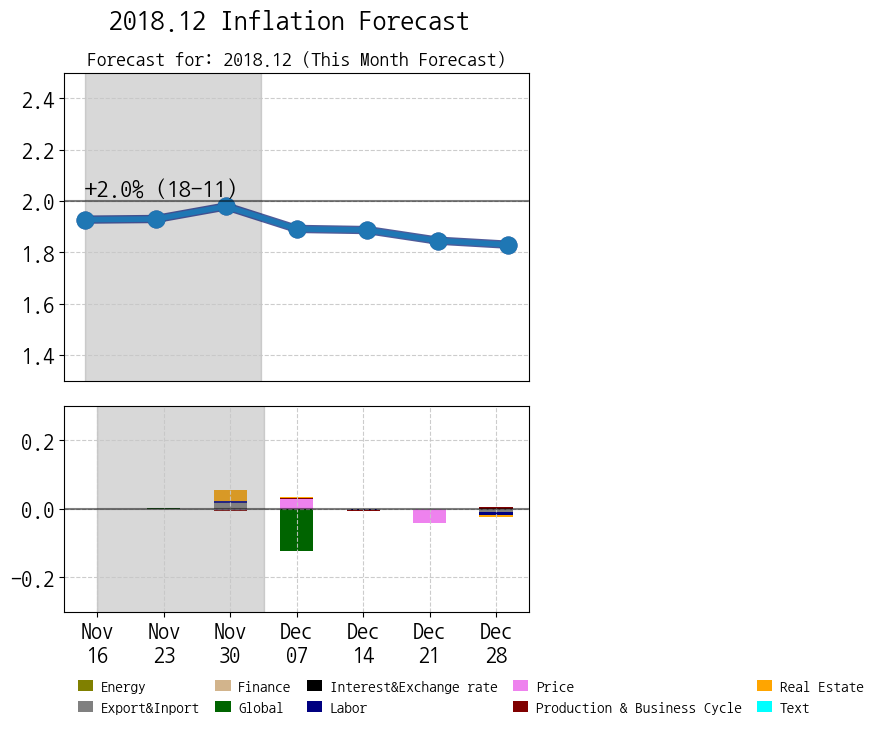

In [77]:
present_results = True
is_Actual = False
year_month = this_month if present_results else '2024-2-1'
    
fm = pd.Timestamp(year_month) + MonthEnd() # 최근 cpi 공표된 다음달

fig, axs = plt.subplots(2, 1, figsize=(6, 7), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0.1})
#, gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3], 'wspace': 0.15, 'hspace': 0.15})

margin = 0.5 #0.5
margin0 = 0.1 #0.1

DECOMP_VAR = {}
print_decomp_var = True

vspec = pd.read_excel(f'{input_s3_dir}/data_list_all_v5.xlsx', index_col = None)
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

#df = pd.read_csv(f'{vintage_s3_dir}/{today:%Y-%m-%d}.csv', index_col=0)
df = pd.read_csv('/content/Inflation_Forecast/input/mdata/2018-12-28.csv', index_col=0)
df.index = pd.to_datetime(df.index)

_, act = get_train_data_v5(df)
act = act.dropna()

pm = fm - MonthEnd(1)

try:
    ymax = act.loc[pm]
    ymin = act.loc[pm]
except KeyError: # 첫째주 금요일 되기 전까지
    pm = fm - MonthEnd(2)
    ymax = act.loc[pm]
    ymin = act.loc[pm]

dymax = 0
dymin = 0

for i, h in enumerate([0]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"{output_s3_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    if DO_TRAIN and not has_s3key():
        PRED_DECOMP = pd.read_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    _, act_vintage = get_train_data_v5(DF_vintages[decomp.index[-1]])
    
    today_str = today.strftime('%Y-%m-%d')
    #print(today_str)

    last_inf = act_vintage.dropna().iloc[-1] # 12월은 당월 공표되어 -2로
    #print(act_vintage)

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'Energy', 'EI':'Export&Inport', 'F':'Finance', 'GB':'Global',
                                    'IE': 'Interest&Exchange rate', 'L':'Labor', 'P':'Price', 'PB':'Production & Business Cycle', 'RE':'Real Estate','T':'Text'})

    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))
    
    bcolors = [(218 / 256, 238 / 256, 243 / 256), (242 / 256, 220 / 256, 219 / 256), (142 / 256, 186 / 256, 66 / 256),
               (192 / 256, 0 / 256, 0 / 256), (0 / 256, 0 / 256, 0 / 256), (251 / 256, 193 / 256, 94 / 256), 
               (33 / 256, 89 / 256, 103 / 256), (119 / 256, 119 / 256, 119 / 256), (255 / 256, 165 / 256, 0 / 256), (0 / 256, 255 / 256, 255 / 256)]
    bcolors = ['olive', 'grey', 'tan', 'darkgreen', 'black', 'navy', 'violet', 'maroon', 'orange', 'cyan']
    
    bok_blue = (0 / 256, 145 / 256, 218 / 256)

    df['forecast'].plot(ax=axs[0], lw=6, marker="o", color=(0.01, 0.09, 0.44), markersize=12, alpha=0.7, label='Ensemble') #color=(0.01, 0.09, 0.44)
    axs[0].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b') # color='b'
    axs[0].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1], color=bcolors)
    axs[1].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1].set_xticklabels(ticklabels, rotation=0)
    axs[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[0].axhline(y=round(last_inf, 1), lw=1.5, color='k', alpha=0.5)
    axs[1].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min(), ymin)
    ymax = max(df.iloc[:, 0].max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max(), dymax)
    #ymin = min(df.iloc[:, 0].min().min(), ymin)
    #ymax = max(df.iloc[:, 0].max().max(), ymax)
    #dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    #axs[0].legend(ncol= 1, loc='lower left', frameon=False, fontsize=11) #, bbox_to_anchor=(0.3, 0.15) #앙상블 범례에 안나오게
    #axs[1].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.2, -0.5), fontsize=14) # 0.08
    axs[1].legend(ncol=5, loc=3, frameon=False, fontsize=11, bbox_to_anchor=(0, -0.57), handlelength=1, handletextpad=0.5, columnspacing=1)
    axs[0].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    axs[1].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    
    if h == 0:
        axs[0].set_title(f"Forecast for: {tm:%Y.%m} (This Month Forecast)", fontsize=14)
    else:
        axs[0].set_title(f"{tm:%Y.%m} \n(After {h}Months Forecast)", fontsize=16)
    axs[0].tick_params(axis="both", labelsize=16)
    axs[1].tick_params(axis="both", labelsize=16)
    axs[0].get_xaxis().set_visible(False)
    axs[0].text(0.0, round(last_inf, 1), f"{last_inf:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    if is_Actual:
        if i > 0:
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()
        try:
            axs[0].text(0.95, 0.93, f"Real Value: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0].transAxes)
        except:
            axs[0].text(0.95, 0.93, f"Real Value: NA", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0].transAxes)

    axs[0].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([0]):
    axs[0].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))
    
fig.suptitle(f"{fm:%Y.%m} Inflation Forecast", fontsize=20, y=0.97)
fig.savefig(f"{local_path}/inf_mail/inf_{fm:%Y.%m}_rtf_h0.png", dpi='figure', bbox_inches='tight')    

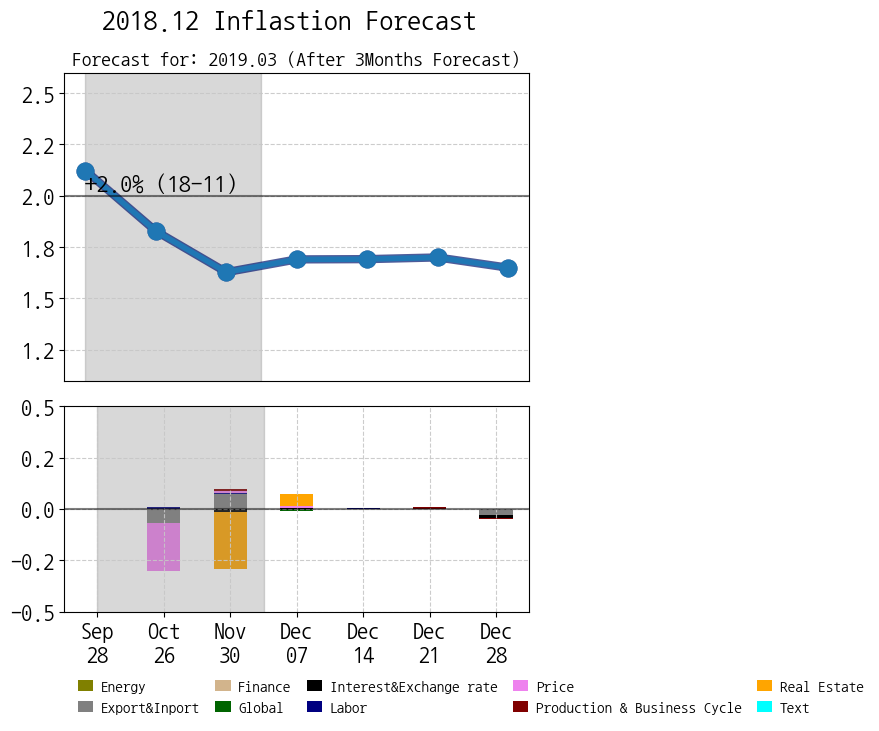

In [78]:
present_results = True
is_Actual = False
year_month = this_month if present_results else '2024-1-1'
    
fm = pd.Timestamp(year_month) + MonthEnd() # 최근 cpi 공표된 다음달

fig, axs = plt.subplots(2, 1, figsize=(6, 7), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0.1})
#, gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3], 'wspace': 0.15, 'hspace': 0.15})

margin = 0.5 #0.5
margin0 = 0.1 #0.1

DECOMP_VAR = {}
print_decomp_var = True

vspec = pd.read_excel(f'{input_s3_dir}/data_list_all_v5.xlsx', index_col = None)
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

#df = pd.read_csv(f'{vintage_s3_dir}/{today:%Y-%m-%d}.csv', index_col=0)
df = pd.read_csv('/content/Inflation_Forecast/input/mdata/2018-12-28.csv', index_col=0)
df.index = pd.to_datetime(df.index)

_, act = get_train_data_v5(df)
act = act.dropna()

pm = fm - MonthEnd(1)

try:
    ymax = act.loc[pm]
    ymin = act.loc[pm]
except KeyError: # 첫째주 금요일 되기 전까지
    pm = fm - MonthEnd(2)
    ymax = act.loc[pm]
    ymin = act.loc[pm]

dymax = 0
dymin = 0

for i, h in enumerate([3]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"{output_s3_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    if DO_TRAIN and not has_s3key():
        PRED_DECOMP = pd.read_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    _, act_vintage = get_train_data_v5(DF_vintages[decomp.index[-1]])
    
    today_str = today.strftime('%Y-%m-%d')
    #print(today_str)

    last_inf = act_vintage.dropna().iloc[-1] # 12월은 당월 공표되어 -2로
    #print(act_vintage)

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'Energy', 'EI':'Export&Inport', 'F':'Finance', 'GB':'Global',
                                    'IE': 'Interest&Exchange rate', 'L':'Labor', 'P':'Price', 'PB':'Production & Business Cycle', 'RE':'Real Estate','T':'Text'})

    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))
    
    bcolors = [(218 / 256, 238 / 256, 243 / 256), (242 / 256, 220 / 256, 219 / 256), (142 / 256, 186 / 256, 66 / 256),
               (192 / 256, 0 / 256, 0 / 256), (0 / 256, 0 / 256, 0 / 256), (251 / 256, 193 / 256, 94 / 256), 
               (33 / 256, 89 / 256, 103 / 256), (119 / 256, 119 / 256, 119 / 256), (255 / 256, 165 / 256, 0 / 256), (0 / 256, 255 / 256, 255 / 256)]
    bcolors = ['olive', 'grey', 'tan', 'darkgreen', 'black', 'navy', 'violet', 'maroon', 'orange', 'cyan']
    
    bok_blue = (0 / 256, 145 / 256, 218 / 256)

    df['forecast'].plot(ax=axs[0], lw=6, marker="o", color=(0.01, 0.09, 0.44), markersize=12, alpha=0.7, label='Ensemble') #color=(0.01, 0.09, 0.44)
    axs[0].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b') # color='b'
    axs[0].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1], color=bcolors)
    axs[1].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1].set_xticklabels(ticklabels, rotation=0)
    axs[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[0].axhline(y=round(last_inf, 1), lw=1.5, color='k', alpha=0.5)
    axs[1].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min(), ymin)
    ymax = max(df.iloc[:, 0].max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max(), dymax)
    #ymin = min(df.iloc[:, 0].min().min(), ymin)
    #ymax = max(df.iloc[:, 0].max().max(), ymax)
    #dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    #axs[0].legend(ncol= 1, loc='lower left', frameon=False, fontsize=11) # , bbox_to_anchor=(0.3, 0.15)########################
    #axs[1].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.2, -0.5), fontsize=14) # 0.08
    axs[1].legend(ncol=5, loc=3, frameon=False, fontsize=11, bbox_to_anchor=(0, -0.57), handlelength=1, handletextpad=0.5, columnspacing=1)
    axs[0].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    axs[1].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    
    if h == 0:
        axs[0].set_title(f"Forecast for: {tm:%Y.%m} (This Month Forecast)", fontsize=14)
    else:
        axs[0].set_title(f"Forecast for: {tm:%Y.%m} (After {h}Months Forecast)", fontsize=14)
    axs[0].tick_params(axis="both", labelsize=16)
    axs[1].tick_params(axis="both", labelsize=16)
    axs[0].get_xaxis().set_visible(False)
    axs[0].text(0.0, round(last_inf, 1), f"{last_inf:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    
    if is_Actual:
        if i > 0:
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()
        try:
            axs[0].text(0.95, 0.93, f"Real Value: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0].transAxes)
        except:
            axs[0].text(0.95, 0.93, f"Real Value: NA", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0].transAxes)

    axs[0].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([3]):
    axs[0].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))
    
fig.suptitle(f"{fm:%Y.%m} Inflastion Forecast", fontsize=20, y=0.97)
fig.savefig(f"{local_path}/inf_mail/inf_{fm:%Y.%m}_rtf_h3.png", dpi='figure', bbox_inches='tight')    

# Save variable factors of decomposition results

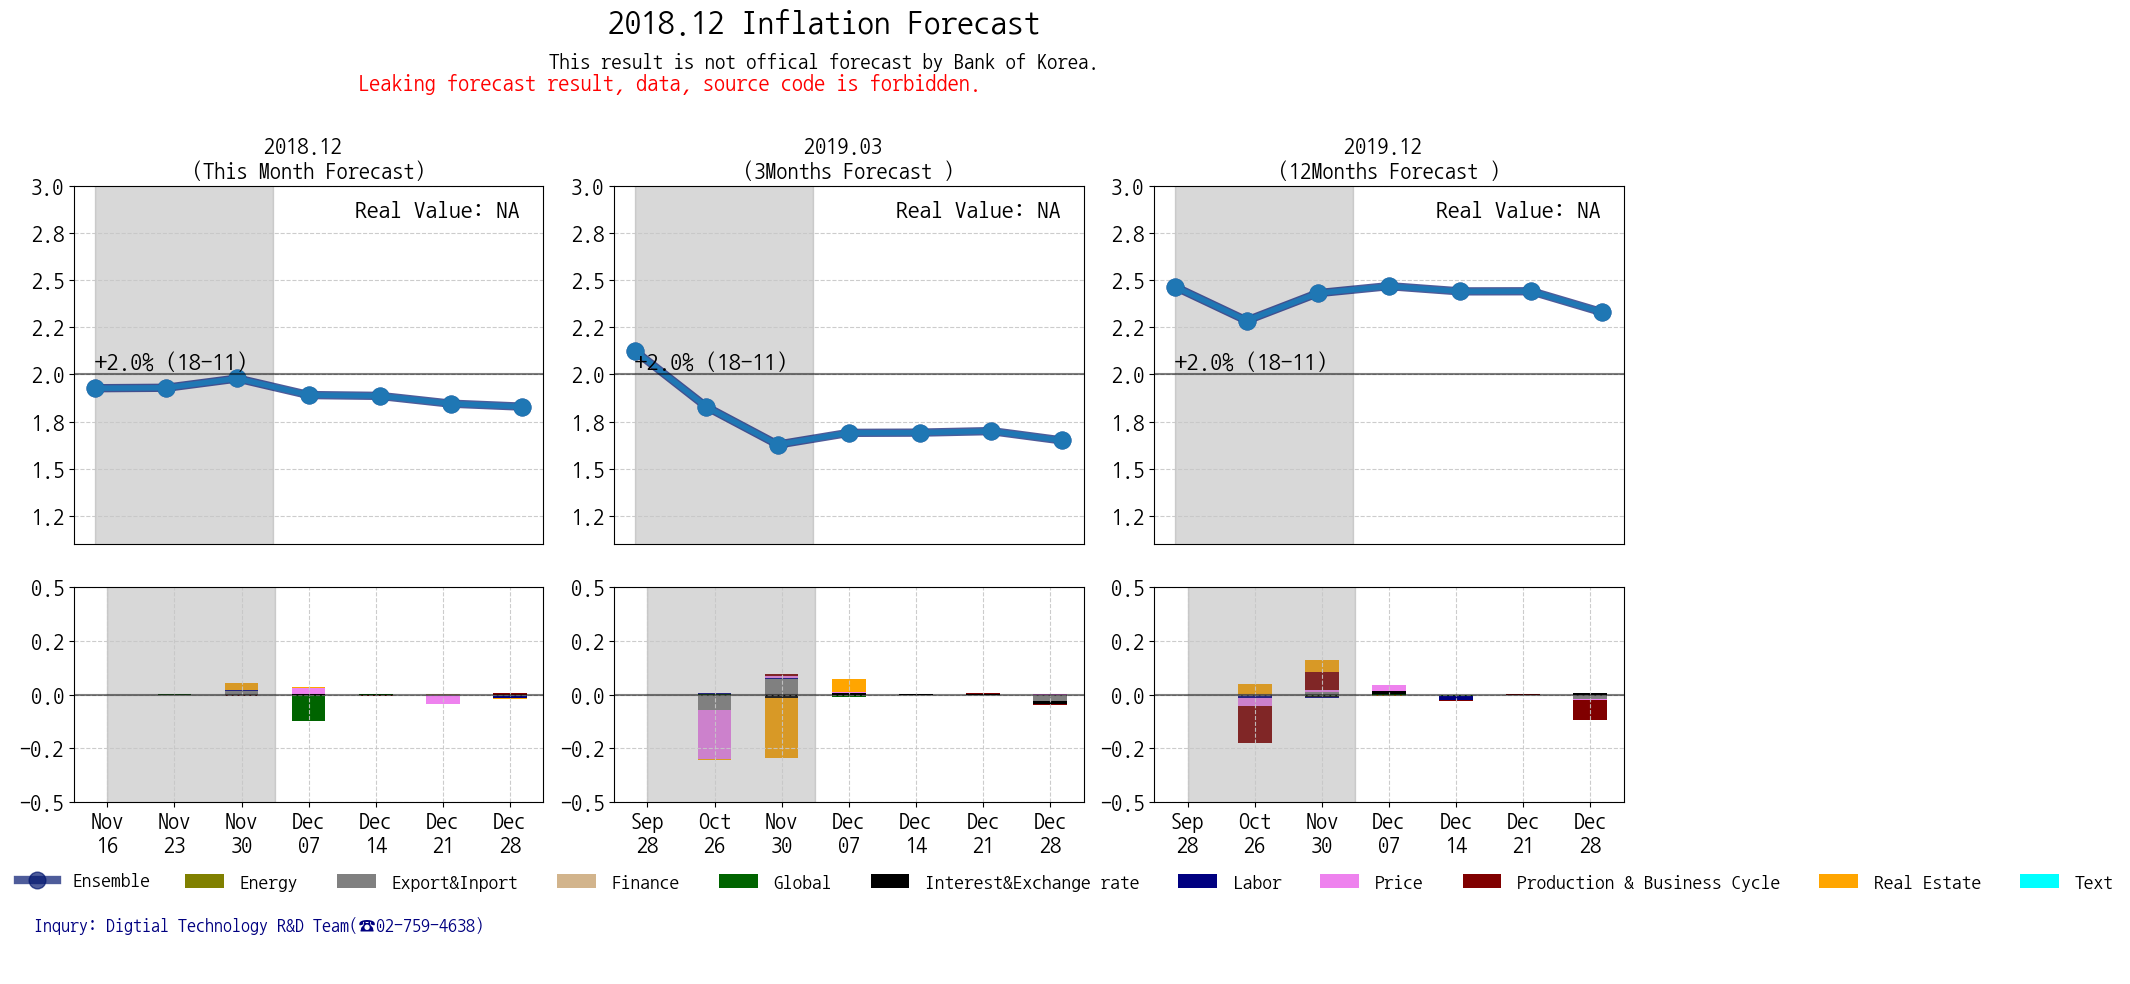

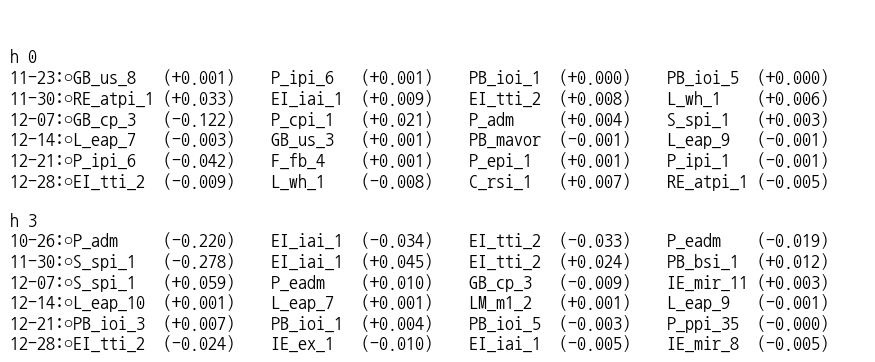

In [80]:
present_results = True
year_month = this_month if present_results else '2024-1-1'
    
fm = pd.Timestamp(year_month) + MonthEnd() # 최근 cpi 공표된 다음달

fig, axs = plt.subplots(2, 3, figsize=(20, 8),
                        gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3],
                                     'wspace': 0.15, 'hspace': 0.15})
margin = 0.5
margin0 = 0.1

DECOMP_VAR = {}
print_decomp_var = True

vspec = pd.read_excel(f'{input_s3_dir}/data_list_all_v5.xlsx', index_col = None)
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

#df = pd.read_csv(f'{vintage_s3_dir}/{today:%Y-%m-%d}.csv', index_col=0)
df = pd.read_csv('/content/Inflation_Forecast/input/mdata/2018-12-28.csv', index_col=0)
df.index = pd.to_datetime(df.index)

_, act = get_train_data_v5(df)
act = act.dropna()

pm = fm - MonthEnd(1)

try:
    ymax = act.loc[pm]
    ymin = act.loc[pm]
except KeyError: # 첫째주 금요일 되기 전까지
    pm = fm - MonthEnd(2)
    ymax = act.loc[pm]
    ymin = act.loc[pm]

dymax = 0
dymin = 0

for i, h in enumerate([0, 3, 12]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"{output_s3_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    if DO_TRAIN and not has_s3key():
        PRED_DECOMP = pd.read_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    _, act_vintage = get_train_data_v5(DF_vintages[decomp.index[-1]])
    
    today_str = today.strftime('%Y-%m-%d')
    #print(today_str)

    last_inf = act_vintage.dropna().iloc[-1] # 12월은 당월 공표되어 -2로
    #print(act_vintage)
    
#     if present_results:
#         inf = pd.read_csv(f'{input_s3_dir}/mdata/{today_str}_raw.csv', index_col = None) #{today_str}_raw.csv
#         inf = inf['P_cpi_1']
#         inf = inf.dropna()
#         inf = inf.pct_change(12)*100
#         last_inf = inf.iloc[-1]
#     else:
#         last_inf = act_vintage.dropna().iloc[-1]

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'Energy', 'EI':'Export&Inport', 'F':'Finance', 'GB':'Global',
                                    'IE': 'Interest&Exchange rate', 'L':'Labor', 'P':'Price', 'PB':'Production & Business Cycle', 'RE':'Real Estate','T':'Text'})

    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))
    
    bcolors = [(218 / 256, 238 / 256, 243 / 256), (242 / 256, 220 / 256, 219 / 256), (142 / 256, 186 / 256, 66 / 256),
               (192 / 256, 0 / 256, 0 / 256), (0 / 256, 0 / 256, 0 / 256), (251 / 256, 193 / 256, 94 / 256), 
               (33 / 256, 89 / 256, 103 / 256), (119 / 256, 119 / 256, 119 / 256), (255 / 256, 165 / 256, 0 / 256), (0 / 256, 255 / 256, 255 / 256)]
    bcolors = ['olive', 'grey', 'tan', 'darkgreen', 'black', 'navy', 'violet', 'maroon', 'orange', 'cyan']
    
    bok_blue = (0 / 256, 145 / 256, 218 / 256)

    df['forecast'].plot(ax=axs[0, i], lw=6, marker="o", color=(0.01, 0.09, 0.44), markersize=12, alpha=0.7, label='Ensemble') #color=(0.01, 0.09, 0.44)
    axs[0, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b') # color='b'
    axs[0, i].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1, i], color=bcolors)
    axs[1, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1, i].set_xticklabels(ticklabels, rotation=0)
    axs[0, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[0, i].axhline(y=round(last_inf, 1), lw=1.5, color='k', alpha=0.5)
    axs[1, i].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    #ymin = min(df.iloc[:, 0].min().min(), ymin)
    #ymax = max(df.iloc[:, 0].max().max(), ymax)
    ymin = min(df.iloc[:, 0].min(), ymin)
    ymax = max(df.iloc[:, 0].max(), ymax)
    #dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max(), dymax)
    axs[0, i].legend(ncol= 1, loc=1, frameon=False, bbox_to_anchor=(0.2, -0.869), fontsize=14) #########################
    axs[1, i].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.2, -0.5), fontsize=14) # 0.08
    axs[0, i].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    axs[1, i].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    
    if h == 0:
        axs[0, i].set_title(f"{tm:%Y.%m} \n(This Month Forecast)", fontsize=16)
    else:
        axs[0, i].set_title(f"{tm:%Y.%m} \n({h}Months Forecast )", fontsize=16)
    axs[0, i].tick_params(axis="both", labelsize=16)
    axs[1, i].tick_params(axis="both", labelsize=16)
    axs[0, i].get_xaxis().set_visible(False)
    axs[0, i].text(0.0, round(last_inf, 1), f"{last_inf:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    if i > 0:
        axs[0, i].get_legend().remove()
        axs[1, i].get_legend().remove()
    try:
        axs[0, i].text(0.95, 0.93, f"Real Value: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                       horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)
    except:
        axs[0, i].text(0.95, 0.93, f"Real Value: NA", fontsize=17,
                       horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)

    axs[0, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([0, 3, 12]):
    axs[0, i].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1, i].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))
    
fig.suptitle(f"{fm:%Y.%m} Inflation Forecast", fontsize=24, y=1.1)

text4 = '\n\nInqury: Digtial Technology R&D Team(☎02-759-4638)\n\n'
fig.text(0.105, -0.1, f'{text4}', fontsize=13, color='navy') # 0., -.15,
warning = [
    "This result is not offical forecast by Bank of Korea.\n",\
    "Leaking forecast result, data, source code is forbidden."]


for i, text in enumerate(warning):
    x_position = 0.423 if i == 1 else 0.5 if i == 0 else 0.592
    color = 'red' if i == 1 else 'black'
    fontsize = 16 if i == 1 else 15
    fig.text(x_position, 1, text, transform=fig.transFigure, ha='center', fontsize=fontsize, color=color)

#fig.savefig(f"{local_path}/plot/inf_{fm:%Y.%m}_rtf.png", dpi='figure', bbox_inches='tight')    
    
fig, ax = plt.subplots(1, 1, figsize=(3,3)) ########수정
text = ''
for h in [0, 3]:
    text += f"\n\nh {h} "
    #print(f"\n\nforecasting horizon: {h}", end='')
    df = DECOMP_VAR[h].drop('forecast', axis=1)
    for i in df.index[1:]:
        vars = np.abs(df).loc[i].nlargest(4).index
        text += f"\n{i:%m-%d}:\t"
        #print(f"\n{i:%m-%d}:", end='\t')
        for v in vars:
            text += f"{v:<10}({df.loc[i, v]:+.3f})    "

if print_decomp_var:
    fig.text(0, 1, text, fontsize=13, horizontalalignment='left', verticalalignment='top') # 0.106, -0.03
ax.axis('off')

fig.savefig(f"{local_path}/inf_mail/inf_{fm:%Y.%m}_var.png", dpi='figure', bbox_inches='tight')